### Dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import Lasso # , LinearRegression 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.stattools import durbin_watson
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Export dependencies list and overwrite requirements.txt with --force
! jupyter nbconvert --output-dir="./requirements" --to script C:\datascience\ml_supervised_linearregression_01\RegressionModel_LinearRegression_Example.ipynb
! cd requirements
! pipreqs --force

[NbConvertApp] Converting notebook C:\datascience\ml_supervised_linearregression_01\RegressionModel_LinearRegression_Example.ipynb to script
[NbConvertApp] Writing 16398 bytes to requirements\RegressionModel_LinearRegression_Example.py
INFO: Successfully saved requirements file in C:\datascience\ml_supervised_linearregression_01\requirements.txt


## <span style='background: lightblue'> 1. Data Collection </span>
Load sample dataset. Shape: 731 rows x 4 columns

In [2]:
# Initial view of the dataset shows that temperature, humidity, and windspeed could be used as predictors for the target variable rentals.
bikes_df = pd.read_csv("./data/bikes.csv")
bikes_df

,temperature,humidity,windspeed,rentals
0,46.716528,0.815969,13.669663,985
1,48.350239,0.800497,15.199782,801
2,34.212394,0.592097,13.247558,1349
3,34.520000,0.623196,11.687963,1562
4,36.800562,0.624643,13.148281,1600
...,...,...,...,...
726,39.102528,0.482493,10.801229,2114
727,39.031972,0.480433,8.996301,3095
728,39.031972,0.717730,11.829425,1341
729,39.243472,0.523039,12.805314,1796


## <span style='background: lightblue'> 2. Data Exploration </span>

In [3]:
# None of the variables have a string type. No need to convert variable(s) to number to build the linear regression model.
bikes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  731 non-null    float64
 1   humidity     731 non-null    float64
 2   windspeed    731 non-null    float64
 3   rentals      731 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 23.0 KB


In [4]:
bikes_df.describe()

,temperature,humidity,windspeed,rentals
count,731.000000,731.000000,731.000000,731.000000
mean,59.509553,0.486937,9.238886,4504.348837
std,15.486114,0.185415,3.379815,1937.211452
min,22.602432,0.000000,0.932208,22.000000
25%,46.117264,0.353548,6.863568,3152.000000
50%,59.758972,0.502227,9.503508,4548.000000
75%,73.048236,0.624671,11.814559,5956.000000
max,90.497028,0.972500,21.126627,8714.000000


<AxesSubplot:>

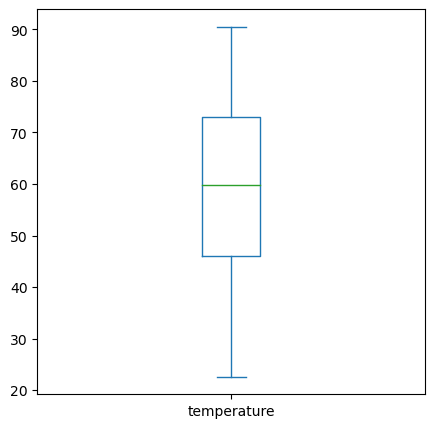

In [5]:
# Check for outliers
bikes_df['temperature'].plot.box(figsize = (5, 5))

<AxesSubplot:>

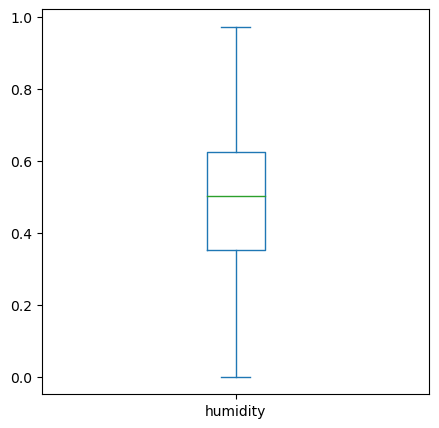

In [6]:
# Check for outliers
bikes_df['humidity'].plot.box(figsize = (5, 5))

<AxesSubplot:>

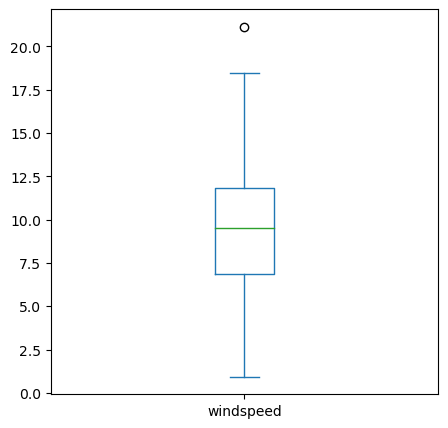

In [7]:
# Check for outliers
bikes_df['windspeed'].plot.box(figsize = (5, 5))

#### Outlier results: For all 3 independent variables only 1 record for windspeed appears to be an outlier.

### <span style='background: lightgrey'>Linear Regression Assumption 1 of 5: Lack of Multicollinearity</span>
The predictors should not be correlated to one another. The smaller the coefficient the smaller the correlation between 2 variables. 1 means a perfect positive correlation, 0 equals no correlation, and -1 means a perfect negative correlation.

In [8]:
# For linear regression to work the features (X predictors) should be independent of each other. 

# To test correlation
bikes_df.corr()

,temperature,humidity,windspeed,rentals
temperature,1.000000,0.055479,-0.024560,0.627494
humidity,0.055479,1.000000,0.898802,-0.717508
windspeed,-0.024560,0.898802,1.000000,-0.758180
rentals,0.627494,-0.717508,-0.758180,1.000000


Pearson correlation coefficient matrix of each variable:
              temperature  humidity  windspeed   rentals
temperature     1.000000  0.055479  -0.024560  0.627494
humidity        0.055479  1.000000   0.898802 -0.717508
windspeed      -0.024560  0.898802   1.000000 -0.758180
rentals         0.627494 -0.717508  -0.758180  1.000000
A significant positive association of 0.8998 between the independent (X) variables only exists between windspeed and humidity. The rest of the associations between the independent variables are very weak. Later we'll see what effect this may have in the accuracy of the model.


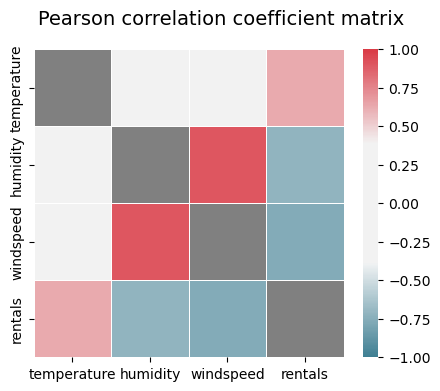

In [9]:
# Visualize the lack of multicollinearity
corr = bikes_df[['temperature', 'humidity', 'windspeed', 'rentals']].corr()
print('Pearson correlation coefficient matrix of each variable:\n', corr)

# Generate a mask for the diagonal cell
mask = np.zeros_like(corr, dtype=bool)
np.fill_diagonal(mask, val=True)

# Initialize matplotlib figure
fig, ax = plt.subplots(figsize=(5, 4))

# Generate figure
cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)
cmap.set_bad('grey')

# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5)
fig.suptitle('Pearson correlation coefficient matrix', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=10)
# fig.tight_layout()

print("A significant positive association of 0.8998 between the independent (X) variables only exists between windspeed and humidity. The rest of the associations between the independent variables are very weak. Later we'll see what effect this may have in the accuracy of the model.")

<AxesSubplot:xlabel='windspeed', ylabel='humidity'>

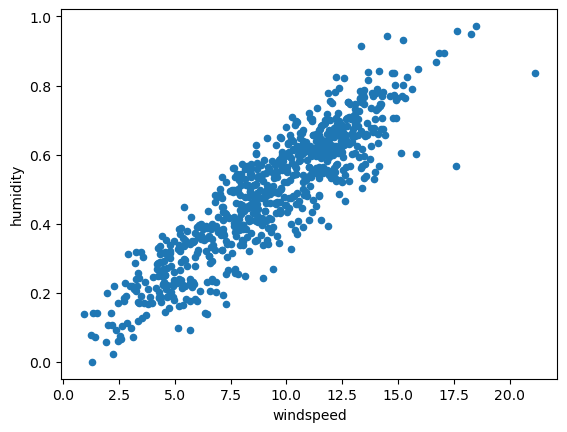

In [10]:
# The scatter plot below confirms the high positive association between windspeed and humidity as shown in the Pearson correlation coefficient results.
bikes_df.plot(kind="scatter", x="windspeed", y="humidity")

### <span style='background: lightgrey'>Linear Regression Assumption 2(a) of 5: Linearity (before running regression)</span>
Check if there is a linear relationship between y (dependent) and each X (independent) variable. A linear relationship is required for linear relationship models.

<AxesSubplot:xlabel='temperature', ylabel='rentals'>

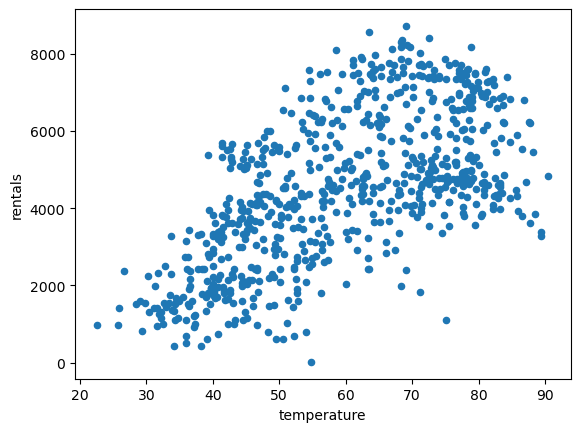

In [11]:
# LINEARITY check

bikes_df.plot(kind="scatter", x="temperature", y="rentals")

<AxesSubplot:xlabel='humidity', ylabel='rentals'>

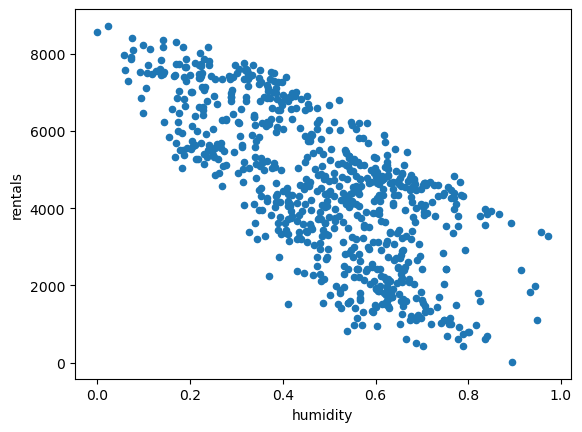

In [12]:
# LINEARITY check
bikes_df.plot(kind="scatter", x="humidity", y="rentals")

<AxesSubplot:xlabel='windspeed', ylabel='rentals'>

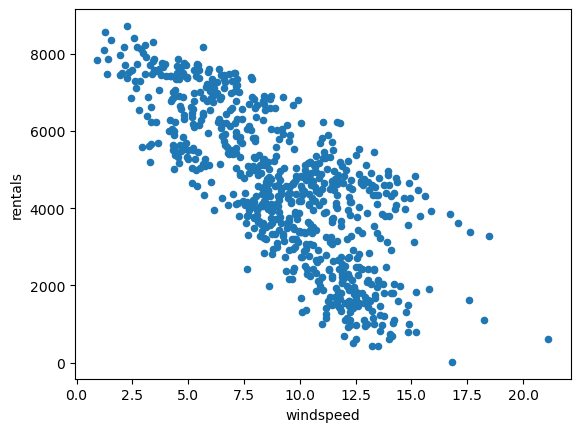

In [13]:
# LINEARITY check
bikes_df.plot(kind="scatter", x="windspeed", y="rentals")

In [14]:
#### Linearity results: All 3 independent variables appear to have a linear tendency.

## <span style='background: lightblue'>3. Data Preparation</span>
Split dataset into y (output, target) and X (input, features) variables

In [15]:
# y dependent (target) variable
output_var = "rentals"
y = bikes_df[[output_var]]
y

,rentals
0,985
1,801
2,1349
3,1562
4,1600
...,...
726,2114
727,3095
728,1341
729,1796


In [16]:
# X independent (feature) variable
input_vars = list(bikes_df.columns) # get all column names
input_vars.remove(output_var) # remove target (y) column
X = bikes_df[input_vars] # assign new data frame to X
X

,temperature,humidity,windspeed
0,46.716528,0.815969,13.669663
1,48.350239,0.800497,15.199782
2,34.212394,0.592097,13.247558
3,34.520000,0.623196,11.687963
4,36.800562,0.624643,13.148281
...,...,...,...
726,39.102528,0.482493,10.801229
727,39.031972,0.480433,8.996301
728,39.031972,0.717730,11.829425
729,39.243472,0.523039,12.805314


In [17]:
# Run K-fold cross-validation on the full dataset
# It's essentially a random split
# On this case the dataset is split into 5 groups (fold) specified by n_splits = 5
# Each split contains 1 test data fold and 4 training data folds. The model is fit on the 4 training folds and the prediction is based on the remaining test fold. In each of the 5 iterations the test group (fold) is a different one.

X = bikes_df[input_vars]
y = bikes_df[[output_var]]

kf = KFold(n_splits=5, shuffle=True, random_state = 42) # random_state argument makes the results repeatable; # random_state = 42 will be removed in production
model = Lasso(alpha=0.1) # choose the alpha hyperparameter based on the model evaluation results in Step #5 to increase accuracy
cv_results = cross_val_score(model, X, y, cv=kf) # returns array of cross-validation scores
print(
    "r2 array: ", cv_results, '\n'
    "Mean of r2: ", np.mean(cv_results), '\n'
    "Std dev: ", np.std(cv_results), '\n'
    "95% confidence interval: ", np.quantile(cv_results, [0.025, 0.975]), '\n \n' 
    "The r2 score of 0.9826 means that 98.26% of our target (y-dependent variable) results can be explained by our 3 features (X-independent variables). This result along with a standard deviation of 0.0023 and a 95% confidence interval between 0.9798 and 0.9854 depict a highly accurate model."
)

r2 array:  [0.9849037  0.97977185 0.98054572 0.98236376 0.9854058 ] 
Mean of r2:  0.9825981669548014 
Std dev:  0.0022562732229608655 
95% confidence interval:  [0.97984924 0.98535559] 
 
The r2 score of 0.9826 means that 98.26% of our target (y-dependent variable) results can be explained by our 3 features (X-independent variables). This result along with a standard deviation of 0.0023 and a 95% confidence interval between 0.9798 and 0.9854 depict a highly accurate model.


In [18]:
# Split data between training and test sets

# 25% of dataset is allocated to test set by default (test_size = 0.25)
# random_state argument makes the results repeatable
# random_state = 1234 argument will be removed in production
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 1234)

In [19]:
# Check the resulting dimensions of all 4 tables
print("Training set (X, y): ", X_train.shape, y_train.shape) 
print("Test set (X, y): ", X_test.shape, y_test.shape)

Training set (X, y):  (548, 3) (548, 1)
Test set (X, y):  (183, 3) (183, 1)


## <span style='background: lightblue'>4. Train the Model (w/ train dataset)</span>

In [20]:
model.fit(X_train, y_train) # LinearRegression() has an optional argument to normalize the data

print("The model was fitted.")

The model was fitted.


In [21]:
# Estimate of the y-intercept

# y-intercept
model.intercept_

array([3800.98840137])

In [22]:
# Estimate of the slope

# slope (regression coefficient)
# The slope results are listed in the order that they appear in the training data data frame. e.g., temperature, humidity, and windspeed
model.coef_

array([   80.34062993, -4652.98979227,  -196.83873408])

###  Below is the estimated regression line that best fits the data. With this information we can estimate what our model will predict in any weather condition (X inputs). This is the equation that can be used in production if our evaluation of the model proves to be satisfactory.

#### y = m * X + b

#### y = m * X - m * X - m * X + b
#### y = (80.35 * X) - (-4665.74 * X) - (-196.22 * X) + 3800.68

#### e.g., If temp=72F, humidity=22%, windspeed=5mph
#### y = (80.35 * 72) - (-4665.74 * .22) - (-196.22 * 5) + 3800.68
#### = 7,578 rentals

## <span style='background: lightblue'>5. Evaluate the Model (test dataset)</span>

In [23]:
# Calculate r2

# Score the predictions r2. The closer this value is to 1 the better the model is.
# r2 = r2_score(y_test, y_predicted) 
# r2 is alo called the coefficient of determination (measures accuracy)
r2 = model.score(X_test, y_test)

print(
    "r2: ", r2, "\n"
    "The r2 score of 0.9821 means that 98.21% of our target (y-dependent variable) results can be explained by our 3 features (X-independent variables) in the test dataset."
) 
# The r2 value of 0.9821 means that our model is able to explain 98.21% of the variability of the output of the test data.
# It tests the ability of the model to generalize. Again, the features explain about 98.21% of the target (rentals) variance.
# Note: The r2 has some pifalls since it's the result of our test set. We need to know what's the performance of the model to generalize with unseen data (e.g., training set). This is why in a previous step we calculated r2 with K-fold cross-validation on the full dataset.
# The mean of r2 using K-fold cross-validation on the full dataset equaled 98.26%
# r2 of the test set equaled 98.21%
# Both r2 results were very similar which support the accuracy of the model.

r2:  0.9820605049266122 
The r2 score of 0.9821 means that 98.21% of our target (y-dependent variable) results can be explained by our 3 features (X-independent variables) in the test dataset.


In [24]:
# Compare predicted values versus the actual values

# Use our model to make predictions
y_predicted = model.predict(X_test)

# MAE (mean absolute error) 
mean_absolute_error(y_test, y_predicted) # The predictions of the model should be off the mark by an average of +/- the result

194.27537486178844

In [25]:
# Concatenate the X and y variables in a data frame for visualization purposes
pd.concat([X_test, y_test], axis=1).reset_index()

,index,temperature,humidity,windspeed,rentals
0,21,22.602432,0.569819,12.235437,981
1,322,45.447528,0.430788,9.515616,3663
2,277,63.142972,0.491240,9.019581,4826
3,524,72.519528,0.223788,5.377084,7736
4,131,62.861000,0.476024,8.148015,4864
...,...,...,...,...,...
178,62,39.737028,0.600859,11.621071,1944
179,483,49.466028,0.460014,9.065312,4220
180,282,65.892472,0.565971,8.224359,5117
181,512,75.974000,0.375785,6.957599,6591


### <span style='background: lightgrey'>Linear Regression Assumption 2(b) of 5: Linearity (after running regression)</span>
Check if there is a linear relationship between y_test and y_prediction

In [26]:
# LINEARITY check prep for next step
# Create dataframe with y_test and y_predicted

# y_test

y_predicted_df = pd.DataFrame(y_predicted, columns=["rentals"])
y_predicted_df


,rentals
0,557.111588
1,3574.778135
2,4812.794834
3,7527.550717
4,5032.500669
...,...
178,1910.219654
179,3850.275771
180,4842.502559
181,6786.737013


In [27]:
# Append y_predicted column to original test set to review results

results = pd.concat([X_test, y_test], axis=1).reset_index()

results['y_predicted'] = y_predicted
results_df = results.rename(columns={'rentals':'y_test'})

results_df

,index,temperature,humidity,windspeed,y_test,y_predicted
0,21,22.602432,0.569819,12.235437,981,557.111588
1,322,45.447528,0.430788,9.515616,3663,3574.778135
2,277,63.142972,0.491240,9.019581,4826,4812.794834
3,524,72.519528,0.223788,5.377084,7736,7527.550717
4,131,62.861000,0.476024,8.148015,4864,5032.500669
...,...,...,...,...,...,...
178,62,39.737028,0.600859,11.621071,1944,1910.219654
179,483,49.466028,0.460014,9.065312,4220,3850.275771
180,282,65.892472,0.565971,8.224359,5117,4842.502559
181,512,75.974000,0.375785,6.957599,6591,6786.737013


There are appears to be a linear relationship between y_predicted and y_test. This reflects a highly accurate model.


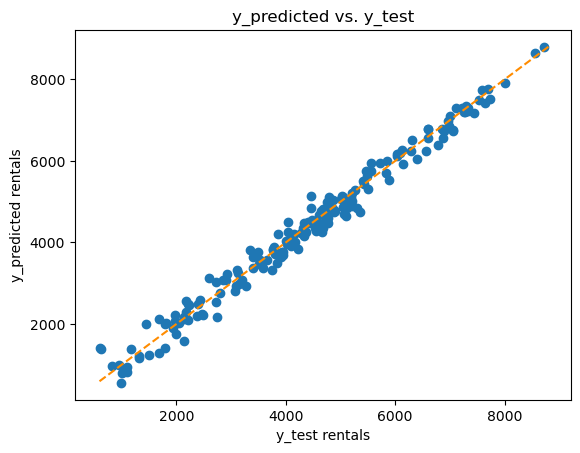

In [28]:
# LINEARITY check

X = y_test
y = y_predicted_df

plt.scatter(X, y)

# Plotting the diagonal line
p1 = max(max(X['rentals']), max(y['rentals'])) # - some interger will change x,y axis range
p2 = min(min(X['rentals']), min(y['rentals'])) # - some interger will change x,y axis range

plt.plot([p1, p2], [p1, p2],  # X and y points
         color='darkorange', linestyle='--')

plt.xlabel('y_test rentals')
plt.ylabel('y_predicted rentals')

plt.title('y_predicted vs. y_test')

print("There are appears to be a linear relationship between y_predicted and y_test. This reflects a highly accurate model.")

### <span style='background: lightgrey'>Linear Regression Assumption 3 of 5: Multivariate Normality</span>
Check the normality of error distribution

(183, 1)
(183,)
p-value from the test Anderson-Darling test below 0.05 generally means non-normal: [0.22329712]


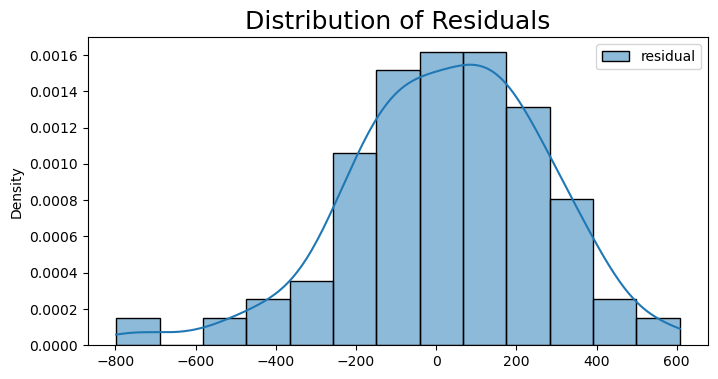

The residuals are normally distributed.
Normally distributed residuals support the use of a linear regression model.


In [29]:
# Performing the test on the residuals

print(y_test.shape)
print(y_predicted.shape)

residuals = y_test - y_predicted.reshape(183, 1) # .reshape used to shape from (183, ) to (183, 1)
# Rename residual column
residuals = residuals.rename(columns={'rentals':'residual'})

p_value = normal_ad(residuals)[1] # TODO: Check what [1] is doing??????
print('p-value from the test Anderson-Darling test below 0.05 generally means non-normal:', p_value)

# Plot the residuals distribution
plt.subplots(figsize=(8, 4))
plt.title('Distribution of Residuals', fontsize=18)
sns.histplot(residuals, kde=True, stat='density')
plt.show()

# Report the normality of the residuals
if p_value < 0.05:
    print('The residuals are not normally distributed')
else:
    print('The residuals are normally distributed.')
    
print('Normally distributed residuals support the use of a linear regression model.')

### <span style='background: lightgrey'>Linear Regression Assumption 4 of 5: Homoscedasticity</span>
Uniform variance for the residuals (prediction errors) of all data points

In [30]:
# Review residuals and make sure the results make sense
residuals.reset_index(drop=True, inplace=True) # Reset residuals index to append column correctly and avoid NaN's
results_df['residuals'] = residuals
results_df

,index,temperature,humidity,windspeed,y_test,y_predicted,residuals
0,21,22.602432,0.569819,12.235437,981,557.111588,423.888412
1,322,45.447528,0.430788,9.515616,3663,3574.778135,88.221865
2,277,63.142972,0.491240,9.019581,4826,4812.794834,13.205166
3,524,72.519528,0.223788,5.377084,7736,7527.550717,208.449283
4,131,62.861000,0.476024,8.148015,4864,5032.500669,-168.500669
...,...,...,...,...,...,...,...
178,62,39.737028,0.600859,11.621071,1944,1910.219654,33.780346
179,483,49.466028,0.460014,9.065312,4220,3850.275771,369.724229
180,282,65.892472,0.565971,8.224359,5117,4842.502559,274.497441
181,512,75.974000,0.375785,6.957599,6591,6786.737013,-195.737013


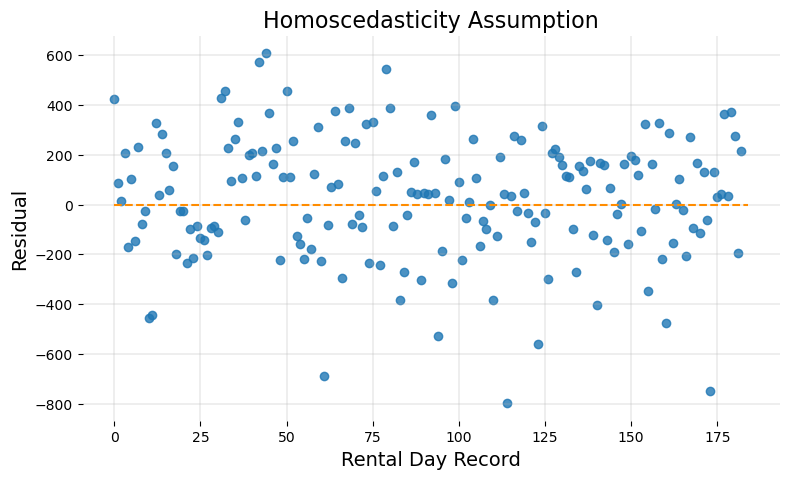

The purpose of this graph is to show where residuals tend to concentrate. Residuals (prediction errors) should concentrate around the X-axis and be uniform.


In [31]:
# Plotting the residuals
plt.subplots(figsize=(9, 5))
plt.scatter(x=residuals.index, y=residuals.residual, alpha=0.8) # x = index number, y = residual value (residuals = y_test - y_predicted)

plt.plot(np.repeat(0, len(residuals.index)+2), color='darkorange', linestyle='--')

plt.ylabel('Residual', fontsize=14)
plt.xlabel('Rental Day Record', fontsize=14)
plt.title('Homoscedasticity Assumption', fontsize=16)
plt.grid(linewidth=0.3)
# plt.xlim([0, 183]) # specify x-axis range
sns.despine(left=True, bottom=True) # remove plot border
plt.show()  

print("The purpose of this graph is to show where residuals tend to concentrate. Residuals (prediction errors) should concentrate around the X-axis and be uniform.")

In [32]:
results_df.describe()

,index,temperature,humidity,windspeed,y_test,y_predicted,residuals
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,354.021858,58.557868,0.496515,9.367174,4377.863388,4351.464612,26.398776
std,206.707362,15.610544,0.175129,3.181917,1831.941097,1813.020689,243.935171
min,7.000000,22.602432,0.000000,1.285864,605.000000,557.111588,-797.785164
25%,172.500000,45.447528,0.380346,7.508777,3105.000000,3086.111134,-124.467960
50%,352.000000,58.137528,0.523039,9.525245,4484.000000,4466.774287,43.061675
75%,528.500000,72.519528,0.616693,11.897060,5443.500000,5471.636802,192.353848
max,730.000000,87.183500,0.914212,15.893534,8714.000000,8799.475632,607.695521


### <span style='background: lightgrey'>Linear Regression Assumption 5 of 5: Independence of Observations<span>
Check for no autocorrelation of residuals (errors) over time

In [33]:
durbinWatson = durbin_watson(residuals)

print('Durbin-Watson:', durbinWatson)
if durbinWatson < 1.5:
    print('Signs of positive autocorrelation', '\n')
    print('Assumption not satisfied')
elif durbinWatson > 2.5:
    print('Signs of negative autocorrelation', '\n')
    print('Assumption not satisfied')
else:
    print('Little to no autocorrelation', '\n')
    print('Assumption satisfied')

Durbin-Watson: [1.78271893]
Little to no autocorrelation 

Assumption satisfied


In [34]:
# Lasso regression

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()), # StandardScaler makes the mean of the distribution 0. About 68% of the values will lie be between -1 and 1. Is used to resize the distribution of values ​​so that the mean of the observed values ​​is 0 and the standard deviation is 1.
    ('model', Lasso())
])

# IMPORTANT: There is no point in picking alpha = 0 ('model__alpha' = 0), that is simply the linear regression.
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)}, # test several values from 0.1 to 10 with 0.1 step. For each value, we calculate the average value of the mean squared error in a 5-folds cross-validation and select the value of α that minimizes such average performance metrics
                      cv = 5, scoring="neg_mean_squared_error",verbose=0
) # verbose=0, to hide response in next step


In [35]:
search.fit(X_train,y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring='neg_mean_squared_error')

The best value for alpha was:  {'model__alpha': 0.1}
Negative Mean Squared Error (-MSE) was:  -66865.14410020472
Asbolute value of coefficients:  [1239.91468642  880.35043372  674.91349165]
['temperature' 'humidity' 'windspeed']
[]


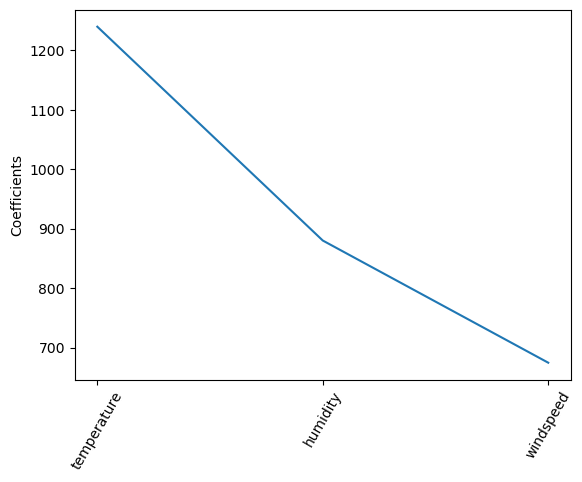

The most important predictor, which the largest absolute value of the coefficients, is temperature. No features of 0 importance where found.


In [36]:
alpha = search.best_params_
print("The best value for alpha was: ", alpha) # Selected automatically in 'model__alpha':np.arange(0.1,10,0.1) in the previous step
                                               # This value can be used to modify the alpha hyperparameter in Step #3 (data preparation section)

# This value can be used to compare which alpha is performing better; The closer to 0 MAE is the better
# MSE is more sensitive to outliers than MAE
mse = search.best_score_
print("Negative Mean Squared Error (-MSE) was: ", mse)

coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)
print("Asbolute value of coefficients: ", importance)

#===============================
#===============================
# print(np.array(features))
X = bikes_df[input_vars]
y = bikes_df[[output_var]]
features = X.columns
print(np.array(features)[importance > 0])
print(np.array(features)[importance == 0]) # If [] blank all features are important (no features equals 0)
#===============================
#===============================
_ = plt.plot(range(len(features)), importance)
_ = plt.xticks(range(len(features)), features, rotation=60)
_ = plt.ylabel('Coefficients')
plt.show()
print("The most important predictor, which the largest absolute value of the coefficients, is temperature. No features of 0 importance where found.")

## Conclusion

Although the bicycle rental dataset used is small I was able to obtain a high degree of accuracy of over 98% in both the full and test sets. Additionally, all 5 assumptions to check the validy of the linear model were satisfied (as noted in steps #1 to #5). Further review of this model and code is required and I don't consider this the final product. But as a general practice of supervised machine learning I think it's a good start.

## Next Steps

Remove the random_state arguments, deploy model into production, and re-check results.